# Image Classification
Horse or Human

## Importing Module

In [1]:
import os
import random
import zipfile
import urllib.request
import tensorflow as tf
import matplotlib.image as mpimg


from pathlib import Path
from matplotlib import pyplot as plt
from keras.preprocessing.image import ImageDataGenerator

print(f'Tensorflow Version : {tf.__version__}')

Tensorflow Version : 2.8.2


## Problem

- Build a Neural Network Model for Horse or Human Dataset. The test will expect it to classify binary classes. Your input layer should accept `150x150` with 3 bytes color as the input shape. Don't use lambda layers in your model.

- The dataset used in this problem is created by Laurence Moroney (laurencemoroney.com). 
- Desired accuracy and validation_accuracy > 83%

### Preparing data

In [2]:
train_url = 'https://github.com/dicodingacademy/assets/releases/download/release-horse-or-human/horse-or-human.zip'
val_url = 'https://github.com/dicodingacademy/assets/raw/main/Simulation/machine_learning/validation-horse-or-human.zip'

train_dir = Path('data/horse-or-human')
val_dir = Path('data/validation-horse-or-human')


list_files = {
    'file_1' : ['horse-or-human.zip', train_url, train_dir],
    'file_2' : ['validation-horse-or-human.zip', val_url, val_dir]
}

Download and Extract data

In [3]:
for data_file in list_files.values():
  try:
    if os.path.isfile(data_file[0]) == False:
      urllib.request.urlretrieve(data_file[1], data_file[0])
      zip_ref = zipfile.ZipFile(data_file[0], 'r')
      zip_ref.extractall(data_file[2])
      zip_ref.close()
      print(f'{data_file[0]} Download and Extract finished')
    else:
      print(f'{data_file[0]} already exist')
  except ValueError as e:
    print(e)

horse-or-human.zip already exist
validation-horse-or-human.zip already exist


### Explore data

Check total file

In [4]:
train_data_path = os.listdir(train_dir)
validation_data_path = os.listdir(val_dir)

# List all data in Train dir
image_count = len(list(train_dir.glob("*/*")))

print(f'Total Image in {train_dir} : {image_count}')
for i in train_data_path:
  target_path = os.path.join(train_dir, i)
  print(f'Total Train Images in {i} : {len(os.listdir(target_path))}')

print()

# List all data in Validation dir
val_image_count = len(list(val_dir.glob("*/*")))
print(f'Total Image in {val_dir} : {val_image_count}')
for i in validation_data_path:
  target_path = os.path.join(val_dir, i)
  print(f'Total Validation Images in {i} : {len(os.listdir(target_path))}')

Total Image in data/horse-or-human : 1027
Total Train Images in horses : 500
Total Train Images in humans : 527

Total Image in data/validation-horse-or-human : 256
Total Validation Images in horses : 128
Total Validation Images in humans : 128


#### Visualize Image

In [5]:
def load_random_imgs_from_folder(folder,label):
  plt.figure(figsize=(15,15))
  for i in range(3):
    file = random.choice(os.listdir(folder))
    image_path = os.path.join(folder, file)
    img=mpimg.imread(image_path)
    ax=plt.subplot(1,3,i+1)
    ax.title.set_text(label)
    plt.xlabel(f'Name: {file}')
    plt.imshow(img)

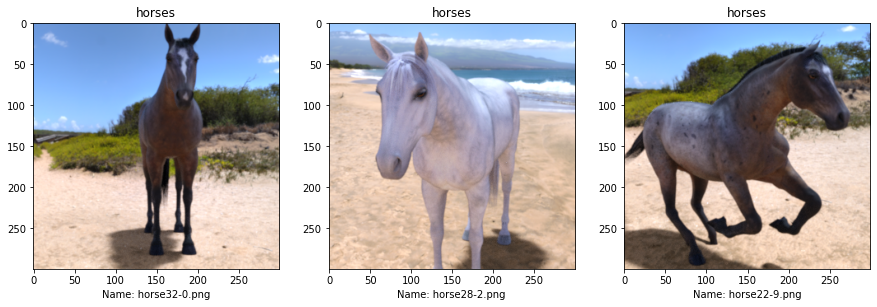

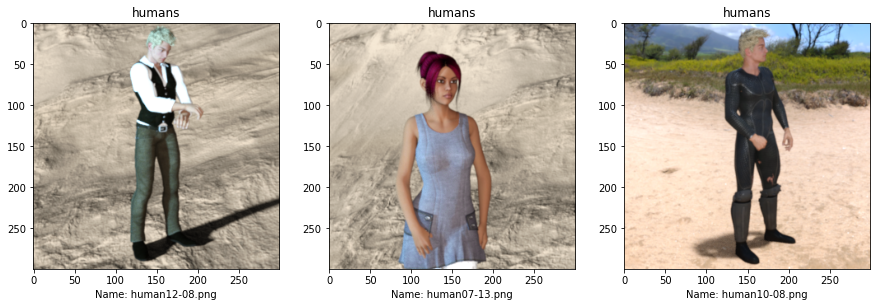

In [6]:
for dir in train_data_path:
  image_dir = os.path.join(train_dir, dir)
  load_random_imgs_from_folder(image_dir, dir)

### Preparing Model

Set Paramters

In [7]:
IMG_SIZE = (150,150)
BATCH_SIZE = 64

#### Image Augmentation
Using [ImageDataGenerator](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator)

In [8]:
train_datagen = ImageDataGenerator(
     rescale=1./255,
     zoom_range=0.1,
     rotation_range=20,
     shear_range=0.2,
     fill_mode='nearest',
     horizontal_flip=True)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle = True,
    class_mode='binary')


test_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = test_datagen.flow_from_directory(
    val_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE//2,
    shuffle = True,
    class_mode='binary')

Found 1027 images belonging to 2 classes.
Found 256 images belonging to 2 classes.


#### Build Model

In [14]:
def build_model():
  """
  Create a model sequential with convolutional layers

  Returns:
      model (tf.keras Model): the Image classifier model
  """

  # Define Params
  lr = 1e-3
  adam = tf.keras.optimizers.Adam(learning_rate=lr) # Optimizer
  losses = tf.keras.losses.BinaryCrossentropy()

  # Define Activation Function
  relu = tf.nn.relu
  sigmoid = tf.nn.sigmoid

  # Define model sequential
  model = tf.keras.Sequential()

  # Define convolutional layers
  model.add(tf.keras.layers.Conv2D(16, 3, padding='same', activation=relu, input_shape=IMG_SIZE + (3,)))
  model.add(tf.keras.layers.MaxPooling2D(2, 2))
  model.add(tf.keras.layers.Conv2D(32, 3, padding='same', activation=relu))
  model.add(tf.keras.layers.MaxPooling2D(2, 2))
  model.add(tf.keras.layers.Conv2D(64, 3, padding='same', activation=relu))
  model.add(tf.keras.layers.MaxPooling2D(2, 2))
  model.add(tf.keras.layers.Conv2D(64, 3, padding='same', activation=relu))
  model.add(tf.keras.layers.MaxPooling2D(2, 2))

  # Define fully connected layers
  model.add(tf.keras.layers.Flatten())
  model.add(tf.keras.layers.Dropout(0.4))
  model.add(tf.keras.layers.Dense(512, activation=relu))
  model.add(tf.keras.layers.Dropout(0.3))
  model.add(tf.keras.layers.Dense(1, activation=sigmoid)) # Output

  # Compile model
  model.compile(optimizer=adam, loss=losses, metrics=['accuracy'])

  # Check Summary Model
  model.summary()

  print('\nModel Succesfully Create')
  
  return model

#### Define Callbacks

In [17]:
model_checkpoint = tf.keras.callbacks.ModelCheckpoint("model.h5", 
                                                      monitor="val_accuracy",
                                                      save_best_only=True,
                                                      verbose=1)

early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", 
                                                  patience=4, 
                                                  mode ="max", 
                                                  verbose=2, 
                                                  restore_best_weights=True)

### Train Model

In [16]:
model = build_model()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 150, 150, 16)      448       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 75, 75, 16)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 75, 75, 32)        4640      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 37, 37, 32)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 37, 37, 64)        18496     
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 18, 18, 64)      

In [18]:
history = model.fit(
      train_generator,
      steps_per_epoch=8,
      epochs=20,
      verbose=1,
      validation_data = validation_generator,
      callbacks=[model_checkpoint, early_stopping],
      validation_steps=8)

Epoch 1/20
8/8 [==============================] - ETA: 0s - loss: 0.6955 - accuracy: 0.5322
Epoch 1: val_accuracy improved from -inf to 0.50000, saving model to model.h5
8/8 [==============================] - 16s 2s/step - loss: 0.6955 - accuracy: 0.5322 - val_loss: 0.6677 - val_accuracy: 0.5000
Epoch 2/20
8/8 [==============================] - ETA: 0s - loss: 0.5618 - accuracy: 0.7384
Epoch 2: val_accuracy improved from 0.50000 to 0.53125, saving model to model.h5
8/8 [==============================] - 17s 2s/step - loss: 0.5618 - accuracy: 0.7384 - val_loss: 1.0912 - val_accuracy: 0.5312
Epoch 3/20
8/8 [==============================] - ETA: 0s - loss: 0.4091 - accuracy: 0.8093
Epoch 3: val_accuracy improved from 0.53125 to 0.72266, saving model to model.h5
8/8 [==============================] - 16s 2s/step - loss: 0.4091 - accuracy: 0.8093 - val_loss: 1.3596 - val_accuracy: 0.7227
Epoch 4/20
8/8 [==============================] - ETA: 0s - loss: 0.3296 - accuracy: 0.8535
Epoch 4: va

### Visualization result

In [19]:
def visualize_result(history):
  '''Function for Visual result'''
  
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  plt.figure(figsize=(15, 6))
  plt.subplot(1, 2, 1)
  plt.plot(acc, label='Training Accuracy')
  plt.plot(val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.title('Training and Validation Accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')

  plt.subplot(1, 2, 2)
  plt.plot(loss, label='Training Loss')
  plt.plot(val_loss, label='Validation Loss')
  plt.legend(loc='upper left')
  plt.title('Training and Validation Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.show()

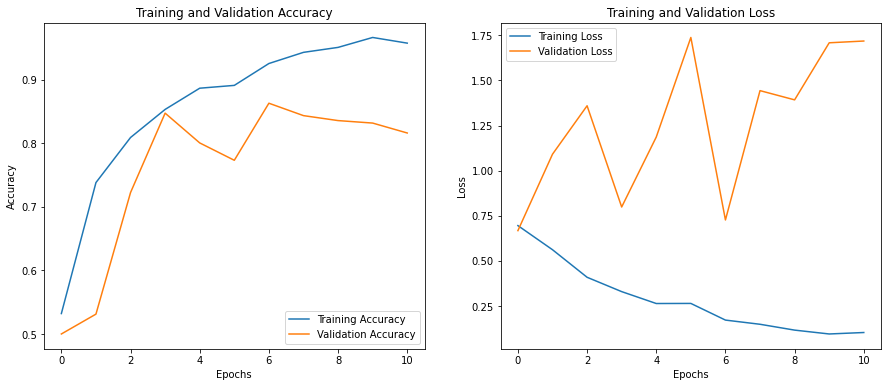

In [20]:
visualize_result(history)

### Download Model

In [ ]:
from google.colab import files
files.download(model.h5)